In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN
import talib
import multiprocessing
from deap import base, creator, tools, algorithms
import warnings

# DEAP creator 객체는 한 번만 생성되어야 합니다.
try:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
except RuntimeError:
    pass
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
except RuntimeError:
    pass

warnings.filterwarnings('ignore')

# 사용자가 제공한 모든 커스텀 모듈들을 가정하고 임포트합니다.
import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
import CandleChart as cc
import ROC as roc
import CV_ESN as cv_esn

# 모든 모듈을 다시 로드하여 최신 상태를 반영
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)
importlib.reload(cc)
importlib.reload(roc)
importlib.reload(cv_esn)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'JPM' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

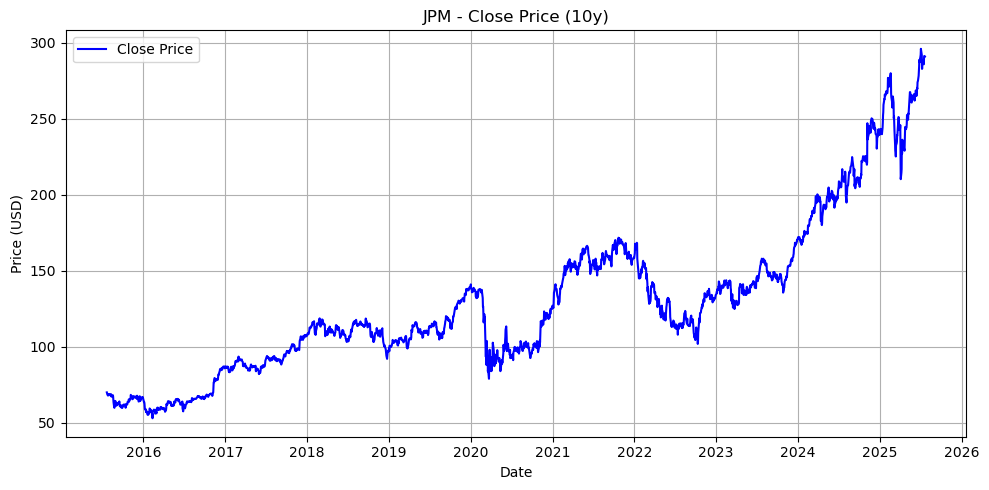

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

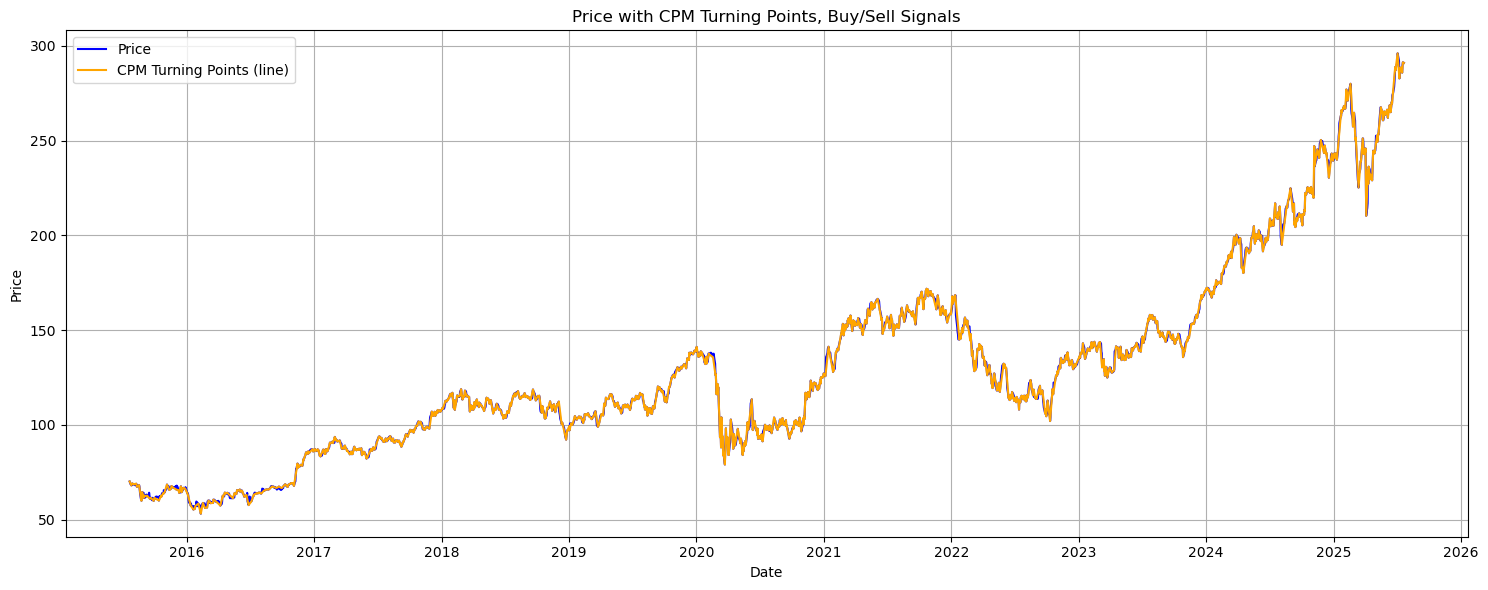

In [7]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [9]:
total_len = len(df)

train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [ ]:
# TA - 이동평군 (MA)
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	1825.98	1792.07	1870.31
1  	40    	inf    	1793.25	inf    
2  	33    	1808.83	1784.51	1828.23
3  	46    	1805.21	1784.47	1840.89
4  	36    	1799.9 	1788.88	1819.17
5  	33    	1797.94	1788.7 	1829   
6  	38    	1800.49	1788.88	1827.44
7  	36    	1796.13	1778.1 	1830.27
8  	40    	1794.26	1778.1 	1815.16
9  	33    	1792.87	1778.1 	1812.33
10 	36    	1793.34	1778.1 	1823.2 
11 	35    	1791.31	1778.1 	1815.74
12 	39    	1790.18	1778.1 	1818.13
13 	36    	1790.32	1778.1 	1837.13
14 	41    	1788.79	1778.1 	1833.95
15 	35    	1782.99	1778.1 	1793.86
16 	39    	1780.22	1778.1 	1796.32
17 	35    	1780   	1778.1 	1795.54
18 	31    	1778.1 	1778.1 	1778.1 
19 	32    	1778.4 	1778.1 	1793.25
20 	41    	1778.71	1778.1 	1793.51
21 	38    	1778.39	1778.1 	1792.65
22 	34    	1778.68	1776.85	1793.25
23 	34    	1777.94	1775.2 	1778.1 
24 	38    	1779.81	1775.2 	1796.01
25 	36    	1777.79	1775.2 	1782.97
26 	36    	1779.37	1772.88	1798.35

In [11]:
N, n, a, b, c = ma_best_params

In [12]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

빈 데이터프레임 반환


In [13]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_19896\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [ ]:
# TA - RSI(상대강도지수)
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	1792.56	1775.57	1793.25
1  	39    	inf    	1773.44	inf    
2  	34    	inf    	1761.42	inf    
3  	36    	inf    	1717.66	inf    
4  	38    	inf    	1717.66	inf    
5  	39    	inf    	1711.52	inf    
6  	45    	inf    	1711.52	inf    
7  	36    	inf    	1711.52	inf    
8  	44    	inf    	1708.78	inf    
9  	40    	inf    	1707.11	inf    
10 	41    	inf    	1697.03	inf    
11 	36    	inf    	1689.99	inf    
12 	40    	inf    	1689.99	inf    
13 	38    	inf    	1692.14	inf    
14 	33    	inf    	1689.25	inf    
15 	37    	inf    	1686.41	inf    
16 	37    	inf    	1685.05	inf    
17 	40    	inf    	1681.24	inf    
18 	35    	inf    	1678.11	inf    
19 	32    	1704.38	1676.11	1781.71
20 	40    	inf    	1676.11	inf    
21 	30    	inf    	1676.11	inf    
22 	40    	1702.89	1673.88	1782.62
23 	39    	1700.56	1673.39	1768.18
24 	41    	1697.57	1673.88	1782.62
25 	37    	1695.16	1672.75	1777.76
26 	38    	inf    	1672.75	inf    


In [15]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [16]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

503 2.287174036412435


In [17]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_19896\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [ ]:
# TA - CancleChart (캔들스틱)
cc_best_params, cc_best_fitness, train_df = cc.run_candlestick_synergy_ga_optimization(train_df, generations=15, population_size=30)
print("Best Parameters: ", cc_best_params)
print("Best Fitness: ", cc_best_fitness)

a, d, e, f, g, window = cc_best_params
test_cc_signals = cc.generate_synergy_signals(test_df, a, d, e, f, g, int(window))
signal_map = test_cc_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['CC_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

In [ ]:
# TA - ROC
roc_best_params, roc_best_fitness, train_df = roc.run_roc_ga_optimization(train_df, generations=15, population_size=30)
print("Best Parameters:", roc_best_params)
print("Best Fitness:", roc_best_fitness)

period, threshold = roc_best_params
test_roc_signals = roc.generate_roc_signals(test_df, int(period), threshold)
signal_map = test_roc_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['ROC_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

In [ ]:
# TA - Stochastic
st_best_params, st_best_fitness, train_df = st.run_stochastic_ga_optimization(train_df, generations=15, population_size=30)

print("Best Parameters:", st_best_params)
print("Best Fitness:", st_best_fitness)

a, b, c, d = st_best_params
test_st_signals = st.generate_stochastic_signals(test_df, a, b, c, d)
signal_map = test_st_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['Stochastic_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

In [ ]:
Technical_Signals = ['MA_Signals', 'RSI_Signals', 'CC_Signals', 'ROC_Signals', 'Stochastic_Signals']

In [ ]:
import CV_ESN
importlib.reload(CV_ESN)

C:\Users\jpran\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [ ]:
best_params_cv, cv_returns = CV_ESN.esn_rolling_forward(
    df=df, # 전체 데이터프레임을 전달
    technical_signals_list=Technical_Signals,
    n_splits=5,  # 5개 폴드로 분할
    pop_size=30,
    num_generations=15
)

final_backtest_stats, final_signals = CV_ESN.perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_cv,
    technical_signals_list=Technical_Signals,
    random_state=42
)


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

gen	nevals	avg    	std    	min     	max   
0  	30    	1.95743	34.8661	-56.8464	97.979


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

1  	25    	10.6129	31.9183	-40.2968	97.979


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

2  	23    	20.1663	30.3963	-34.3145	97.979


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

3  	28    	11.518 	18.2845	-20.0176	53.5922


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

4  	27    	8.83038	24.9673	-47.4251	72.253 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

5  	19    	19.0529	21.8374	-27.9753	72.253 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

6  	21    	20.8096	27.8495	-38.9166	72.253 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

7  	30    	22.0214	27.8493	-18.9433	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

8  	21    	34.7473	35.2595	-25.4602	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

9  	27    	42.2712	35.7064	-14.4334	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

10 	25    	42.1343	37.4564	-10.7292	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

11 	20    	55.9167	31.7078	-8.39477	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

12 	23    	60.6925	33.2991	2.02558 	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

13 	22    	45.5587	36.1171	-5.00104	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

14 	25    	56.3004	37.3896	-5.994  	103.947


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

15 	22    	70.8477	33.4566	-21.882 	103.947

GA 최적화 완료 - 최적 하이퍼파라미터: [202.06285641451922, 1.1178127874541999, 0.12419684349737253, 0.48956444963130796]
GA 최적화 완료 - 최고 Return [%]: 103.9469


In [ ]:
print(best_params_ga)

[202.06285641451922, 1.1178127874541999, 0.12419684349737253, 0.48956444963130796]


In [22]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 202
  spectral_radius: 1.1178
  sparsity: 0.1242
  signal_threshold: 0.4896


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                  20394.69331
Equity Peak [$]                   20746.79323
Return [%]                          103.94693
Buy & Hold Return [%]                88.63533
Return (Ann.) [%]                     42.9112
Volatility (Ann.) [%]                32.56497
CAGR [%]                             27.76436
Sharpe Ratio                          1.31771
Sortino Ratio                         2.80877
Calmar Ratio                          1.72663
Alpha [%]                             21.8987
Beta                                  0.92568
Max. Drawdown [%]                   -24.85261
Avg. Drawdown [%]                    -2.90935
Max. Drawdown Duration      126 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                    0
Win Rate 

In [23]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

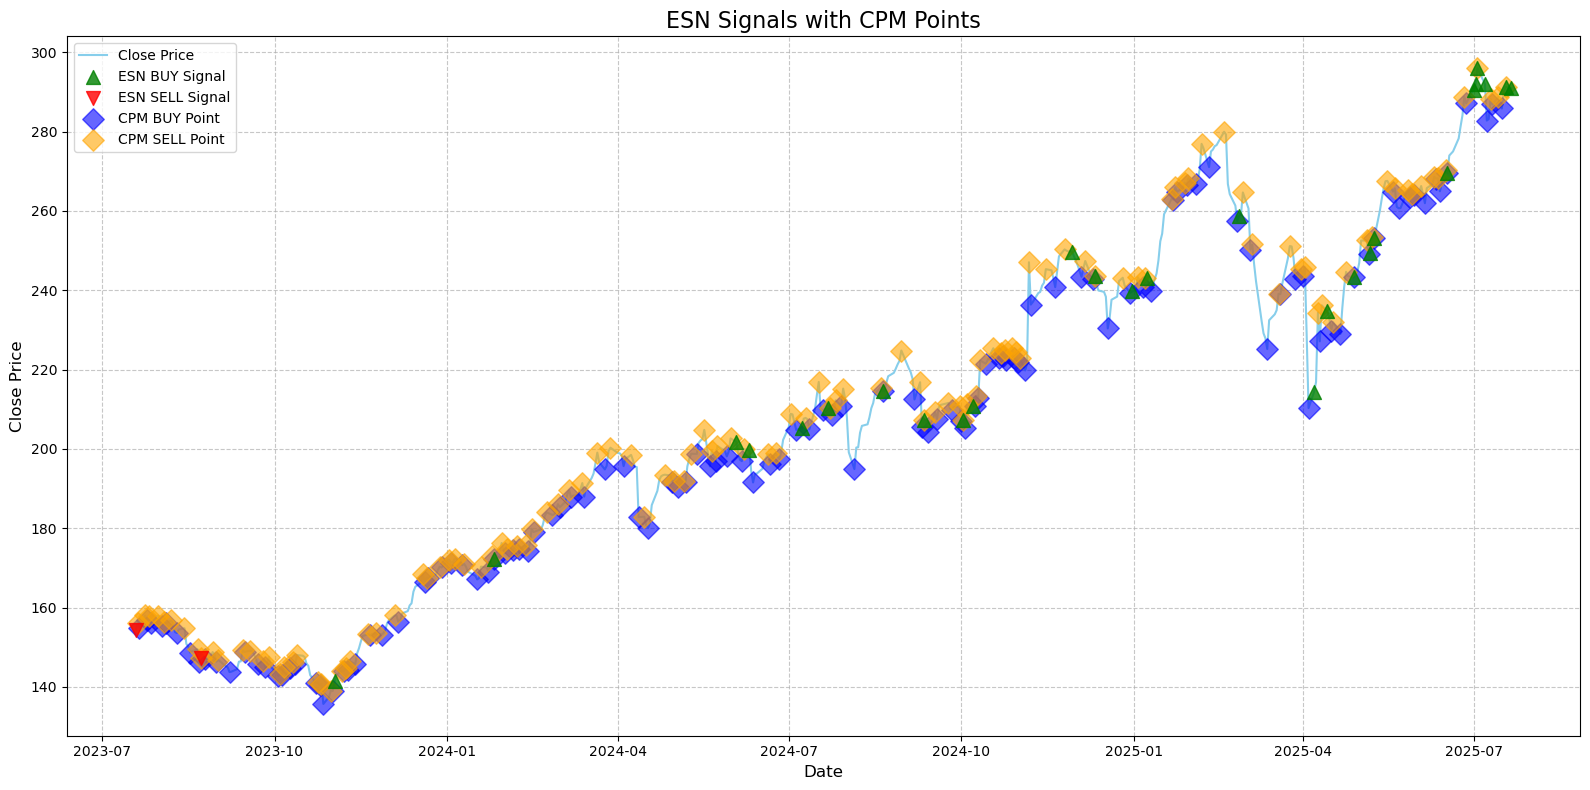

In [24]:
plot_signals(test_df, final_signals)